In [1]:
import logging

import numpy as np
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline
logging.getLogger().setLevel(logging.INFO)


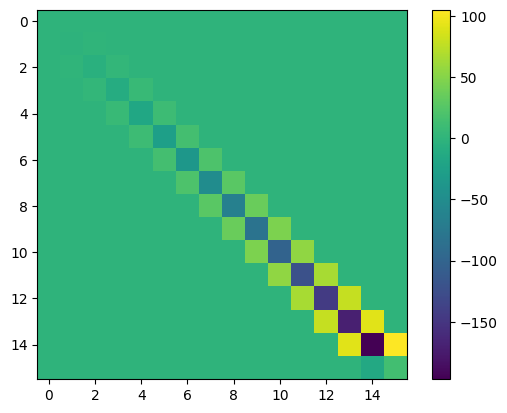

In [61]:
# from tests.black_scholes.hamiltonian import generateBlackScholesHamiltonian
from qnute.hamiltonian import Hamiltonian
from tests.black_scholes import BlackScholesInfo, Basis, BoundaryConditions
from qnute.hamiltonian.examples.position_operator import generatePositionHamiltonian
from qnute.hamiltonian.examples.finite_difference.first_derivative import generateFirstDerivativeHamiltonian1D
from qnute.hamiltonian.examples.finite_difference.laplacian import generateLaplaceHamiltonian1D

from qnute.hamiltonian import hm_list_tensor
from qnute.hamiltonian.construction import get_lowerLeft_hm_list, get_lowerRight_hm_list

def lowerRightHam(num_qbits:int) -> Hamiltonian:
    return Hamiltonian(get_lowerRight_hm_list(num_qbits), num_qbits)
def lowerRight1Ham(num_qbits:int) -> Hamiltonian:
    assert num_qbits >= 2
    return Hamiltonian(hm_list_tensor(get_lowerRight_hm_list(num_qbits-1), 
                                      get_lowerLeft_hm_list(1) ), num_qbits)
def lowerRight2Ham(num_qbits:int) -> Hamiltonian:
    assert num_qbits >=2
    if num_qbits == 2:
        return Hamiltonian(hm_list_tensor(get_lowerLeft_hm_list(1),
                                          get_lowerRight_hm_list(1) ), num_qbits)
    return Hamiltonian(hm_list_tensor(get_lowerRight_hm_list(num_qbits-2),
                                      hm_list_tensor(get_lowerLeft_hm_list(1),
                                                     get_lowerRight_hm_list(1)) ), num_qbits)


def foo(bs_data:BlackScholesInfo,
                                    num_qbits:int
                                    )->Hamiltonian:
    assert n >= 2, 'Black Scholes Hamiltonian requries at least two qubits!'
    N = 2**num_qbits
    dS = bs_data.Smax / (N-1)

    if bs_data.basis == Basis.S:
        BSHam = (
            (SHam:=generatePositionHamiltonian(num_qbits, 0, dS)) * generateFirstDerivativeHamiltonian1D(num_qbits, dS) * (bs_data.r-bs_data.q) 
            + SHam*SHam*generateLaplaceHamiltonian1D(num_qbits, dS)*((bs_data.sigma**2)/2) 
            + Hamiltonian.Identity(num_qbits)*(-bs_data.r)
            )
        match bs_data.BC:
            case BoundaryConditions.ZERO_AFTER:
                pass
            case BoundaryConditions.ZERO_AT:
                BC_Ham = lowerRightHam(num_qbits) * (bs_data.r + (bs_data.sigma*bs_data.Smax/dS)**2)
                BC_Ham += lowerRight1Ham(num_qbits) * -((bs_data.sigma*bs_data.Smax/dS)**2 / 2 - (bs_data.r-bs_data.q)*bs_data.Smax/(2*dS))
                BSHam += BC_Ham
            case BoundaryConditions.LINEAR:
                BC_Ham = lowerRightHam(num_qbits) * ((bs_data.sigma*bs_data.Smax/dS)**2 + (bs_data.r-bs_data.q)*bs_data.Smax/dS)
                BC_Ham += lowerRight1Ham(num_qbits) * -((bs_data.sigma*bs_data.Smax/dS)**2 / 2 + (bs_data.r-bs_data.q)*bs_data.Smax/(2*dS))
                BSHam += BC_Ham
            case BoundaryConditions.PDE:
                BC_Ham = lowerRightHam(num_qbits) * ((sigma*Smax/dS)**2 + (r-q)*Smax/dS)
                BC_Ham += lowerRight1Ham(num_qbits) * -((bs_data.sigma*bs_data.Smax/dS)**2 *3/2 + (bs_data.r-bs_data.q)*bs_data.Smax/2*dS)
                BC_Ham += lowerRight2Ham(num_qbits) * (bs_data.sigma*bs_data.Smax/dS)**2
                BSHam += BC_Ham
            case _:
                raise NotImplementedError('These boundary conditions are not yet implemented!')
    else:
        raise NotImplementedError('x-Basis hamiltonian not implemented yet!')
    
    return BSHam



bs_data = BlackScholesInfo(r:=1.0, q:=0, sigma:=1.0, basis:=Basis.S, 
                           Smax:=3, BC:=BoundaryConditions.LINEAR)
BSHam = foo(bs_data, n:=4)

# print(BSHam)
# print(BSHam.get_matrix().real)
plt.imshow(BSHam.get_matrix().real)
plt.colorbar()
plt.show()

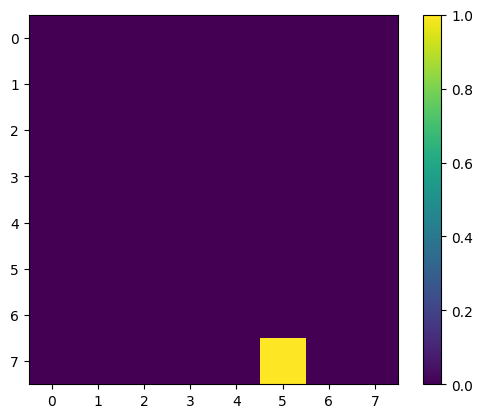

In [59]:
plt.imshow((lowerRight2Ham(n).get_matrix().real))
plt.colorbar()

In [57]:
print((lowerRight2Ham(n).get_matrix().real))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [44]:


import numpy as np
N = 2**n
dS = Smax/(N-1)
alpha = np.zeros(N)
beta = np.zeros(N)

for i in range(N):
    alpha[i] = (sigma*i)**2 / (2) - (r-q)*(i)/(2)
    beta[i] = (sigma*i)**2 / (2) + (r-q)*(i)/(2)

print(alpha)
print(beta)
print()

A = np.zeros((N,N))
for i in range(N):
    if i-1 > 0:
        A[i][i-1] = -alpha[i]
    A[i][i] = r + alpha[i] + beta[i]
    if i+1 < N:
        A[i][i+1] = -beta[i]

print(A)
print()

gamma2 = -(sigma*Smax/dS)**2
gamma1 = (sigma*Smax/dS)**2 + (r-q)*Smax/dS
gamma0 = r - gamma1 - gamma2
B = np.zeros(A.shape)
B[:,:] = A[:,:]
B[N-1][N-1] = gamma0
B[N-1][N-2] = gamma1
B[N-1][N-3] = gamma2

print(B)

[ 0.  0.  1.  3.  6. 10. 15. 21.]
[ 0.  1.  3.  6. 10. 15. 21. 28.]

[[  1.  -0.   0.   0.   0.   0.   0.   0.]
 [  0.   2.  -1.   0.   0.   0.   0.   0.]
 [  0.  -1.   5.  -3.   0.   0.   0.   0.]
 [  0.   0.  -3.  10.  -6.   0.   0.   0.]
 [  0.   0.   0.  -6.  17. -10.   0.   0.]
 [  0.   0.   0.   0. -10.  26. -15.   0.]
 [  0.   0.   0.   0.   0. -15.  37. -21.]
 [  0.   0.   0.   0.   0.   0. -21.  50.]]

[[  1.  -0.   0.   0.   0.   0.   0.   0.]
 [  0.   2.  -1.   0.   0.   0.   0.   0.]
 [  0.  -1.   5.  -3.   0.   0.   0.   0.]
 [  0.   0.  -3.  10.  -6.   0.   0.   0.]
 [  0.   0.   0.  -6.  17. -10.   0.   0.]
 [  0.   0.   0.   0. -10.  26. -15.   0.]
 [  0.   0.   0.   0.   0. -15.  37. -21.]
 [  0.   0.   0.   0.   0. -49.  56.  -6.]]


In [20]:
r - (2*(sigma*Smax/dS)**2 + (r-q)*Smax/dS)

-20.0

In [28]:
-(sigma*Smax/dS)**2 - (r-q)*Smax/dS

-12.0

In [26]:
r+alpha[3]+beta[3]

10.0

In [29]:
A[N-1,N-1] + (-(sigma*Smax/dS)**2 - (r-q)*Smax/dS)

-2.0